## Conhecendo o DeltaLake

[Delta Lake](https://docs.delta.io/latest/index.html) é um formato de armazenamento de código aberto baseado em arquivo que fornece transações ACID (Atomicidade, Consistência, Isolamento e Durabilidade), manipulação escalonável de metadados e unifica o processamento de dados em batch e streaming.

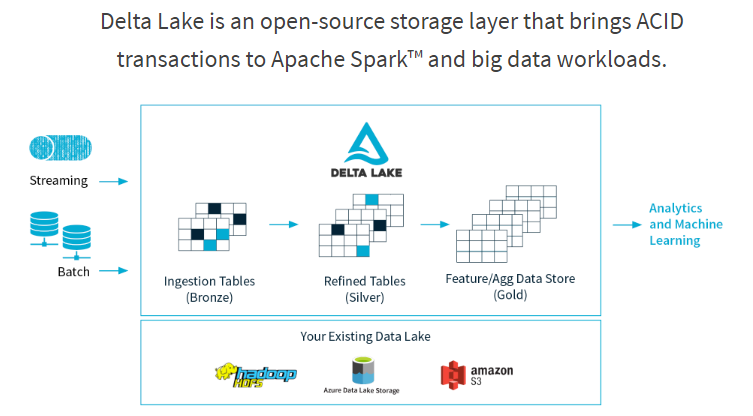

In [1]:
#Instalando as dependencias
!pip install -r requirements.txt -q

In [2]:
import pyspark

spark = pyspark.sql.SparkSession.builder.appName("JobDeltaLake") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:0.8.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.databricks.delta.schema.autoMerge.enabled","true") \
    .config("spark.databricks.delta.autoOptimize.optimizeWrite","true") \
    .config("spark.databricks.delta.optimizeWrite.enabled","true") \
    .config("spark.databricks.delta.vacuum.parallelDelete.enabled","true") \
    .getOrCreate()

from delta.tables import *
from pyspark.sql.functions import *

from datetime import date

In [3]:
spark

Criando os *paths*:

* **path_input**: equivale ao local de entrada dos dados (sobrescreve os dados).
* **path_output**: equivale ao local de armazenamento dos dados (faz o merge).

In [4]:
path_input = 'data/input/sample.parquet/'

In [5]:
path_output = 'data/output/sample.parquet/'

In [6]:
!rm -rf data/

### Criando os datasets

In [7]:
df_1 = spark.createDataFrame(
    [
       (1, date.today(), 'Primeira linha dataframe'),
       (2, date.today(), 'Segunda linha dataframe'),
    ],
        ['id','data', 'texto']
)

df_1.show(truncate=False)

+---+----------+------------------------+
|id |data      |texto                   |
+---+----------+------------------------+
|1  |2021-06-14|Primeira linha dataframe|
|2  |2021-06-14|Segunda linha dataframe |
+---+----------+------------------------+



Vamos salvar o arquivo em formato parquet, para emular a leitura de um bucket no Storage com arquivos .parquet.

In [8]:
#Escrevendo o arquivo no formato parquet
df_1.write.format("parquet").mode("overwrite").save(path_input)

In [9]:
#Fazendo a leitura do arquivo no formato parquet
df_1 = spark.read.format("parquet").option("inferSchema", "false").load(path_input)
df_1.show(truncate=False)

+---+----------+------------------------+
|id |data      |texto                   |
+---+----------+------------------------+
|1  |2021-06-14|Primeira linha dataframe|
|2  |2021-06-14|Segunda linha dataframe |
+---+----------+------------------------+



In [10]:
#Escrevendo o dataframe em formato delta
df_1.write.format("delta").save(path_output)

### Lendo os dados

In [11]:
#Verificando se o arquivo foi salvo no formato delta
df = spark.read.format("delta").load(path_output)
df.show(truncate=False)

+---+----------+------------------------+
|id |data      |texto                   |
+---+----------+------------------------+
|1  |2021-06-14|Primeira linha dataframe|
|2  |2021-06-14|Segunda linha dataframe |
+---+----------+------------------------+



In [12]:
#Vamos criar um segundo dataframe
df_2 = spark.createDataFrame(
    [
        (1, date.today(), 'Primeira linha dataframe'),
        (2, date.today(), 'Segunda linha att dataframe'),
        (3, date.today(), 'Terceira linha dataframe'),

    ],
        ['id','data', 'texto']
)

df_2.show(truncate=False)

+---+----------+---------------------------+
|id |data      |texto                      |
+---+----------+---------------------------+
|1  |2021-06-14|Primeira linha dataframe   |
|2  |2021-06-14|Segunda linha att dataframe|
|3  |2021-06-14|Terceira linha dataframe   |
+---+----------+---------------------------+



In [13]:
#Escrevendo em tabela
table = DeltaTable.forPath(spark, path_output)

Note que a tabela contém apenas os registros do primeiro datafreme, que estão salvos no path_output. Nesse momento os path de input e output contém o mesmo conteúdo

In [14]:
table.toDF().show(truncate=False)

+---+----------+------------------------+
|id |data      |texto                   |
+---+----------+------------------------+
|1  |2021-06-14|Primeira linha dataframe|
|2  |2021-06-14|Segunda linha dataframe |
+---+----------+------------------------+



Agora vamos realizar o merge dos nossos dataframes.

![deltalake](images/upsert.jpg)

In [15]:
#Fazendo o merge dos arquivos
table.alias("persisteddata") .merge( \
   df_2.alias("newdata"), \
    "persisteddata.id = newdata.id") \
.whenMatchedUpdateAll() \
.whenNotMatchedInsertAll() \
.execute()

Dataframe atualizado:

* O id 3 foi acrescentado no dataframe.
* A compente texto do id 2 foi atualizado.

In [16]:
#Verificando a nova tabela
table.toDF().show(truncate=False)

+---+----------+---------------------------+
|id |data      |texto                      |
+---+----------+---------------------------+
|2  |2021-06-14|Segunda linha att dataframe|
|1  |2021-06-14|Primeira linha dataframe   |
|3  |2021-06-14|Terceira linha dataframe   |
+---+----------+---------------------------+



### Vacuum

Com o tempo, mais arquivos serão acumulados em sua tabela Delta; muitos dos arquivos mais antigos podem não ser mais necessários porque representam versões anteriormente substituídas de dados (por exemplo, ATUALIZAR, EXCLUIR, etc.). 

Portanto, você pode remover arquivos não mais referenciados por uma tabela Delta e são mais antigos do que o limite de retenção executando o VACUUM na tabela.

O VACUUM não é acionado automaticamente, quando acionado o limite de retenção padrão é de 7 dias.

O VACUUM não limpa os arquivos de log; os arquivos de log são limpos automaticamente após pontos de verificação são escritos.

Outra observação para satisfazer o requisito de exclusão é que você também precisa excluí-lo de seu armazenamento de blob. Portanto, como prática recomendada, sempre que o pipeline ETL é definido você deve aplicar a política de retenção desde o início para que não precise se preocupe mais tarde.

In [17]:
table.vacuum()

DataFrame[]

In [18]:
#Verificando o Schema
table.toDF().printSchema()

root
 |-- id: long (nullable = true)
 |-- data: date (nullable = true)
 |-- texto: string (nullable = true)



### Verificando as versões

In [19]:
df = spark.read.format("delta").option("versionAsOf", 0).load(path_output)
df.show(truncate=False)

+---+----------+------------------------+
|id |data      |texto                   |
+---+----------+------------------------+
|1  |2021-06-14|Primeira linha dataframe|
|2  |2021-06-14|Segunda linha dataframe |
+---+----------+------------------------+



In [20]:
df = spark.read.format("delta").option("versionAsOf", 1).load(path_output)
df.show(truncate=False)

+---+----------+---------------------------+
|id |data      |texto                      |
+---+----------+---------------------------+
|2  |2021-06-14|Segunda linha att dataframe|
|1  |2021-06-14|Primeira linha dataframe   |
|3  |2021-06-14|Terceira linha dataframe   |
+---+----------+---------------------------+

